In [1]:
#!pip install psycopg2
import os
import pandas as pd
import numpy as np
import psycopg2
import pandas.io.sql as psql
import matplotlib.pyplot as plt


## Load, Clean and Merge Starbucks location file and Country Codes
- Load Starbucks Locations csv and clean data to drop null values and unnecessary data
- Join 2 digit country codes to map starbucks location with the country name
- Rename columns and replace unmatch values and variants in country names
- Test for null data

In [2]:
starbucks_df = pd.read_csv("Data-Source/Starbucks Locations.csv")
starbucks_df.head()

,Brand,Store Number,Store Name,Ownership Type,Street Address,City,State/Province,Country,Postcode,Phone Number,Timezone,Longitude,Latitude
0,Starbucks,47370-257954,"Meritxell, 96",Licensed,"Av. Meritxell, 96",Andorra la Vella,7,AD,AD500,376818720,GMT+1:00 Europe/Andorra,1.53,42.51
1,Starbucks,22331-212325,Ajman Drive Thru,Licensed,"1 Street 69, Al Jarf",Ajman,AJ,AE,NaN,NaN,GMT+04:00 Asia/Dubai,55.47,25.42
2,Starbucks,47089-256771,Dana Mall,Licensed,Sheikh Khalifa Bin Zayed St.,Ajman,AJ,AE,NaN,NaN,GMT+04:00 Asia/Dubai,55.47,25.39
3,Starbucks,22126-218024,Twofour 54,Licensed,Al Salam Street,Abu Dhabi,AZ,AE,NaN,NaN,GMT+04:00 Asia/Dubai,54.38,24.48
4,Starbucks,17127-178586,Al Ain Tower,Licensed,"Khaldiya Area, Abu Dhabi Island",Abu Dhabi,AZ,AE,NaN,NaN,GMT+04:00 Asia/Dubai,54.54,24.51


In [3]:
digit_cities_df = pd.read_csv("Data-Source/two_digit.csv")
digit_cities_df = digit_cities_df.rename(columns={"Code": "Country"})
digit_cities_df.head()

,Name,Country
0,Afghanistan,AF
1,Ã…land Islands,AX
2,Albania,AL
3,Algeria,DZ
4,American Samoa,AS


In [4]:
merge_df = pd.merge(starbucks_df, digit_cities_df, on='Country')
merge_df = merge_df.drop('Postcode', 1)
merge_df = merge_df.drop('Phone Number', 1)
merge_df = merge_df.drop('Timezone', 1)
merge_df = merge_df.drop('Street Address', 1)
merge_df = merge_df.drop('City', 1)
merge_df = merge_df.drop('Longitude', 1)
merge_df = merge_df.drop('Latitude', 1)
merge_df = merge_df.drop('Ownership Type', 1)
merge_df = merge_df.rename(columns={"Brand" : "brand",
                                    "Store Number" : "store_number",
                                    "Store Name": "store_name",
                                    "State/Province" : "state_province",
                                    "Country": "country_code", "Name":"country"})
merge_df = merge_df.replace('Viet Nam', 'Vietnam')
merge_df = merge_df.replace('Russian Federation', 'Russia')
merge_df.head()

,brand,store_number,store_name,state_province,country_code,country
0,Starbucks,47370-257954,"Meritxell, 96",7,AD,Andorra
1,Starbucks,22331-212325,Ajman Drive Thru,AJ,AE,United Arab Emirates
2,Starbucks,47089-256771,Dana Mall,AJ,AE,United Arab Emirates
3,Starbucks,22126-218024,Twofour 54,AZ,AE,United Arab Emirates
4,Starbucks,17127-178586,Al Ain Tower,AZ,AE,United Arab Emirates


In [5]:
merge_df.isnull().sum()

brand             0
store_number      0
store_name        0
state_province    0
country_code      0
country           0
dtype: int64

In [6]:
merge_df.to_csv("Resources/starbucks_locations.csv")

## Obtain List of Countries from Starbucks Location file merge
- This will be our first list of countries, to be used to combine with our other reports later

In [7]:
country_counts = merge_df['country'].value_counts()
country_counts_df = pd.DataFrame(country_counts)
country_counts_df = country_counts_df.reset_index()
country_counts_df = country_counts_df.rename(columns={"index": "country", "country":"count"})
country_counts_df = country_counts_df.drop('count',1)
country_counts_df.head()

,country
0,United States
1,China
2,Canada
3,Japan
4,"Korea, Republic of"


In [8]:
country_counts_df.to_csv('Resources/starbucks_country_list.csv')

## Load, Clean, and Join all Happiness Report Data
- Loaded 2015, 2016, and 2017 Happiness Report
- Dropped columns that are not needed for database
- Renamed and reordered columns and country names for consistency across all reports
- Added year specific markers to respective reports

In [9]:
# Load 2016 World Happiness Report
happy_df_2016 = pd.read_csv("Data-Source/World Happiness Report 2016.csv")
happy_df_2016 = happy_df_2016.drop('Region', 1)
happy_df_2016 = happy_df_2016.drop('Lower Confidence Interval', 1)
happy_df_2016 = happy_df_2016.drop('Upper Confidence Interval', 1)
happy_df_2016["Year"] = "2016"
happy_df_2016 = happy_df_2016.rename(columns={"Country" : "country",
                                              "Happiness Rank" : "happiness_rank",
                                              "Happiness Score" : "happiness_score",
                                              "Economy (GDP per Capita)" : "economy_gdp_per_capita",
                                              "Family" : "family",
                                              "Health (Life Expectancy)" : "health_life_expectancy",
                                              "Freedom" : "freedom",
                                              "Generosity" : "generosity",
                                              "Trust (Government Corruption)" : "trust_government_corruption",
                                              "Dystopia Residual" : "dystopia_residual",
                                              "Year" : "year"})
happy_df_2016.head()

,country,happiness_rank,happiness_score,economy_gdp_per_capita,family,health_life_expectancy,freedom,trust_government_corruption,generosity,dystopia_residual,year
0,Denmark,1,7.526,1.44178,1.16374,0.79504,0.57941,0.44453,0.36171,2.73939,2016
1,Switzerland,2,7.509,1.52733,1.14524,0.86303,0.58557,0.41203,0.28083,2.69463,2016
2,Iceland,3,7.501,1.42666,1.18326,0.86733,0.56624,0.14975,0.47678,2.83137,2016
3,Norway,4,7.498,1.57744,1.12690,0.79579,0.59609,0.35776,0.37895,2.66465,2016
4,Finland,5,7.413,1.40598,1.13464,0.81091,0.57104,0.41004,0.25492,2.82596,2016


In [10]:
# Load 2017 World Happiness Report
happy_df_2017 = pd.read_csv("Data-Source/World Happiness Report 2017.csv")
happy_df_2017 = happy_df_2017.drop('Whisker.high', 1)
happy_df_2017 = happy_df_2017.drop('Whisker.low', 1)
happy_df_2017["Year"] = "2017"
happy_df_2017 = happy_df_2017.rename(columns={"Country" : "country",
                                              "Happiness.Rank" : "happiness_rank",
                                              "Happiness.Score" : "happiness_score",
                                              "Economy..GDP.per.Capita." : "economy_gdp_per_capita",
                                              "Family" : "family",
                                              "Health..Life.Expectancy." : "health_life_expectancy",
                                              "Freedom" : "freedom",
                                              "Generosity" : "generosity",
                                              "Trust..Government.Corruption." : "trust_government_corruption",
                                              "Dystopia.Residual" : "dystopia_residual",
                                              "Year" : "year"})
happy_df_2017.head()

,country,happiness_rank,happiness_score,economy_gdp_per_capita,family,health_life_expectancy,freedom,generosity,trust_government_corruption,dystopia_residual,year
0,Norway,1,7.537,1.616463,1.533524,0.796667,0.635423,0.362012,0.315964,2.277027,2017
1,Denmark,2,7.522,1.482383,1.551122,0.792566,0.626007,0.355280,0.400770,2.313707,2017
2,Iceland,3,7.504,1.480633,1.610574,0.833552,0.627163,0.475540,0.153527,2.322715,2017
3,Switzerland,4,7.494,1.564980,1.516912,0.858131,0.620071,0.290549,0.367007,2.276716,2017
4,Finland,5,7.469,1.443572,1.540247,0.809158,0.617951,0.245483,0.382612,2.430182,2017


In [11]:
# load 2015 World Happiness Report
happy_df_2015 = pd.read_csv("Data-Source/World Happiness Report 2015.csv")
happy_df_2015 = happy_df_2015.drop('Region', 1)
happy_df_2015 = happy_df_2015.drop('Standard Error', 1)
happy_df_2015["Year"] = "2015"
happy_df_2015 = happy_df_2015.rename(columns={"Country" : "country",
                                              "Happiness Rank" : "happiness_rank",
                                              "Happiness Score" : "happiness_score",
                                              "Economy (GDP per Capita)" : "economy_gdp_per_capita",
                                              "Family" : "family",
                                              "Health (Life Expectancy)" : "health_life_expectancy",
                                              "Freedom" : "freedom",
                                              "Generosity" : "generosity",
                                              "Trust (Government Corruption)" : "trust_government_corruption",
                                              "Dystopia Residual" : "dystopia_residual",
                                              "Year" : "year"})
happy_df_2015.head()

,country,happiness_rank,happiness_score,economy_gdp_per_capita,family,health_life_expectancy,freedom,trust_government_corruption,generosity,dystopia_residual,year
0,Switzerland,1,7.587,1.39651,1.34951,0.94143,0.66557,0.41978,0.29678,2.51738,2015
1,Iceland,2,7.561,1.30232,1.40223,0.94784,0.62877,0.14145,0.43630,2.70201,2015
2,Denmark,3,7.527,1.32548,1.36058,0.87464,0.64938,0.48357,0.34139,2.49204,2015
3,Norway,4,7.522,1.45900,1.33095,0.88521,0.66973,0.36503,0.34699,2.46531,2015
4,Canada,5,7.427,1.32629,1.32261,0.90563,0.63297,0.32957,0.45811,2.45176,2015


In [12]:
happy_df_2017 = happy_df_2017[['country','happiness_rank','happiness_score','economy_gdp_per_capita','family',
                     'health_life_expectancy', 'freedom',
                     'trust_government_corruption', 'generosity', 'dystopia_residual', 'year']]
happy_df_2017.head()

,country,happiness_rank,happiness_score,economy_gdp_per_capita,family,health_life_expectancy,freedom,trust_government_corruption,generosity,dystopia_residual,year
0,Norway,1,7.537,1.616463,1.533524,0.796667,0.635423,0.315964,0.362012,2.277027,2017
1,Denmark,2,7.522,1.482383,1.551122,0.792566,0.626007,0.400770,0.355280,2.313707,2017
2,Iceland,3,7.504,1.480633,1.610574,0.833552,0.627163,0.153527,0.475540,2.322715,2017
3,Switzerland,4,7.494,1.564980,1.516912,0.858131,0.620071,0.367007,0.290549,2.276716,2017
4,Finland,5,7.469,1.443572,1.540247,0.809158,0.617951,0.382612,0.245483,2.430182,2017


In [13]:
frames = [happy_df_2015, happy_df_2016, happy_df_2017]
joined_happy_df= pd.concat(frames)
joined_happy_df = joined_happy_df.replace('Taiwan', 'Taiwan, Province of China')
joined_happy_df = joined_happy_df.replace('Bolivia', 'Bolivia, Plurinational State of')
joined_happy_df = joined_happy_df.replace('Somaliland region', 'Somaliland Region')
joined_happy_df = joined_happy_df.replace('Taiwan Province of China', 'Taiwan, Province of China')
joined_happy_df = joined_happy_df.replace('Hong Kong S.A.R., China', 'Hong Kong')
joined_happy_df.head()

,country,happiness_rank,happiness_score,economy_gdp_per_capita,family,health_life_expectancy,freedom,trust_government_corruption,generosity,dystopia_residual,year
0,Switzerland,1,7.587,1.39651,1.34951,0.94143,0.66557,0.41978,0.29678,2.51738,2015
1,Iceland,2,7.561,1.30232,1.40223,0.94784,0.62877,0.14145,0.43630,2.70201,2015
2,Denmark,3,7.527,1.32548,1.36058,0.87464,0.64938,0.48357,0.34139,2.49204,2015
3,Norway,4,7.522,1.45900,1.33095,0.88521,0.66973,0.36503,0.34699,2.46531,2015
4,Canada,5,7.427,1.32629,1.32261,0.90563,0.63297,0.32957,0.45811,2.45176,2015


## Obtain and Concatenate Country Lists from Happiness Report and Starbucks Locations
- Obtain master list from Happiness report in case there is missing data from the original country list to join both together.
- Clean up the joined list to ensure consistency across both country lists

In [14]:
country_counts_2 = joined_happy_df['country'].value_counts()
country_counts_df2 = pd.DataFrame(country_counts_2)
country_counts_df2 = country_counts_df2.reset_index()
country_counts_df2 = country_counts_df2.rename(columns={"index": "country", "country":"count"})
country_counts_df2 = country_counts_df2.drop('count',1)
country_counts_df2.head()

,country
0,Portugal
1,Nicaragua
2,Hong Kong
3,Costa Rica
4,Trinidad and Tobago


In [15]:
country_counts_df2.to_csv("Resources/happiness_country_list.csv")

In [16]:
frames2 = [country_counts_df, country_counts_df2]
joined_country_df= pd.concat(frames2)
joined_country_df = joined_country_df.replace('Bolivia', 'Bolivia, Plurinational State of')
joined_country_df = joined_country_df.replace('CuraÃƒÂ§ao', 'Curacao')
joined_country_df = joined_country_df.replace('Hong Kong S.A.R., China', 'Hong Kong')
joined_country_df = joined_country_df.replace('Somaliland region', 'Somaliland Region')
joined_country_df = joined_country_df.replace('Taiwan Province of China', 'Taiwan, Province of China')
joined_country_df = joined_country_df.replace('Taiwan', 'Taiwan, Province of China')
joined_country_df = joined_country_df.replace('Viet Nam', 'Vietnam')
joined_country_df = joined_country_df.drop_duplicates()
joined_country_df = joined_country_df.sort_values(by=['country'])
joined_country_df.head()

,country
110,Afghanistan
141,Albania
134,Algeria
72,Andorra
70,Angola


In [17]:
joined_country_df.to_csv("Resources/joined_country_list.csv")

# Visualization

Text(0, 0.5, '# of Starbucks Location')

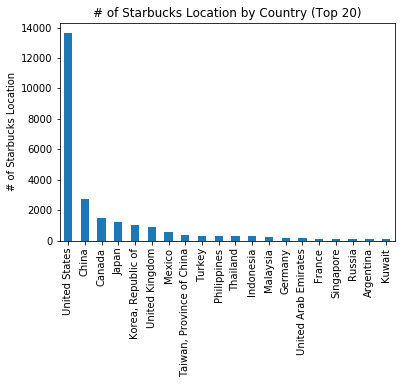

In [18]:
# number of starbucks location by country(top 20)
country_counter = merge_df['country'].value_counts()
country_counter
merge_df['country'].value_counts()[:20].plot(kind='bar',title='# of Starbucks Location by Country (Top 20)')
plt.ylabel('# of Starbucks Location')

In [19]:
# top 20 happiest countries (2017)
sorted_happy_df = joined_happy_df.sort_values(by='happiness_rank',ascending=True)
new_sorted_happy_df_2017= sorted_happy_df[sorted_happy_df.year == '2017']
new_sorted_happy_df_2017_view = new_sorted_happy_df_2017[['country','happiness_rank']]
new_sorted_happy_df_2017_view[:20]

,country,happiness_rank
0,Norway,1
1,Denmark,2
2,Iceland,3
3,Switzerland,4
4,Finland,5
5,Netherlands,6
6,Canada,7
7,New Zealand,8
8,Sweden,9
9,Australia,10


## Import SQLAlchemy, Create Database Connection and Push Data

In [29]:
from sqlalchemy import create_engine
rds_connection_string = "postgres<password>@localhost:5432/Country-Happiness"
engine = create_engine(f'postgresql://{rds_connection_string}')
engine.table_names()

['happiness', 'country_code', 'starbucks_locations']

In [30]:
joined_country_df.to_sql(name='country_code', con=engine, if_exists='append', index=False)

In [31]:
merge_df.to_sql(name='starbucks_locations', con=engine, if_exists='append', index=False)

In [32]:
joined_happy_df.to_sql(name='happiness', con=engine, if_exists='append', index=False)

# Querys

In [24]:
# a view of Starbucks_Locations table
dataframe = psql.read_sql("SELECT * FROM Starbucks_Locations", engine)
dataframe.head()

,brand,store_number,store_name,state_province,country_code,country
0,Starbucks,47370-257954,"Meritxell, 96",7,AD,Andorra
1,Starbucks,22331-212325,Ajman Drive Thru,AJ,AE,United Arab Emirates
2,Starbucks,47089-256771,Dana Mall,AJ,AE,United Arab Emirates
3,Starbucks,22126-218024,Twofour 54,AZ,AE,United Arab Emirates
4,Starbucks,17127-178586,Al Ain Tower,AZ,AE,United Arab Emirates


In [25]:
# a view of Happiness table
dataframe = psql.read_sql("SELECT * FROM Happiness", engine)
dataframe.head()

,country,happiness_rank,happiness_score,economy_gdp_per_capita,family,health_life_expectancy,freedom,trust_government_corruption,generosity,dystopia_residual,year
0,Switzerland,1.0,7.587,1.39651,1.34951,0.94143,0.66557,0.41978,0.29678,2.51738,2015.0
1,Iceland,2.0,7.561,1.30232,1.40223,0.94784,0.62877,0.14145,0.43630,2.70201,2015.0
2,Denmark,3.0,7.527,1.32548,1.36058,0.87464,0.64938,0.48357,0.34139,2.49204,2015.0
3,Norway,4.0,7.522,1.45900,1.33095,0.88521,0.66973,0.36503,0.34699,2.46531,2015.0
4,Canada,5.0,7.427,1.32629,1.32261,0.90563,0.63297,0.32957,0.45811,2.45176,2015.0


In [26]:
# a view of country_code table
dataframe = psql.read_sql("SELECT * FROM country_code", engine)
dataframe.head()

,country
0,Afghanistan
1,Albania
2,Algeria
3,Andorra
4,Angola


In [27]:
# number of Starbucks stores by country
dataframe = psql.read_sql("SELECT country, count(*) as counter FROM Starbucks_Locations group by country", engine)
dataframe.head()

,country,counter
0,Indonesia,268
1,Brunei Darussalam,5
2,Luxembourg,2
3,Czech Republic,28
4,Sweden,18
